# Analisis de profit vs. items (intercepto forzado a 0)

Este cuaderno construye modelos de regresiin lineal sin intercepto para estimar el
profit esperado por item en cada combinaciin `(profile, priority, payment_method, day_type)`.
Se asume que si un cliente no lleva items, el profit es exactamente 0.


## 1. Configuracion e importaciones

In [3]:
import math
import re
from pathlib import Path
from dataclasses import dataclass
from typing import Iterable, List, Tuple

import numpy as np
import pandas as pd
from scipy import stats

CANDIDATE_ROOTS = ('outputs_teoricos', 'outputs_teóricos')
DATA_ROOTS: List[Path] = []
for root_name in CANDIDATE_ROOTS:
    path = Path(root_name).expanduser()
    if path.exists():
        DATA_ROOTS.append(path.resolve())

if not DATA_ROOTS:
    # fallback: busca cualquier carpeta que empiece con outputs_te y termine en ricos
    for cand in Path.cwd().glob('outputs_te*ricos'):
        if cand.is_dir():
            DATA_ROOTS.append(cand.resolve())
    if not DATA_ROOTS:
        raise RuntimeError('No se encontraron carpetas outputs_teoricos u outputs_teóricos')

CUSTOMER_COLUMNS = [
    'customer_id',
    'profile',
    'priority',
    'payment_method',
    'items',
    'total_profit_clp',
    'outcome',
]

DAY_NUM_TO_TYPE = {
    1: 'Tipo 1',
    2: 'Tipo 1',
    3: 'Tipo 2',
    4: 'Tipo 1',
    5: 'Tipo 2',
    6: 'Tipo 2',
    7: 'Tipo 3',
}

MIN_OBS = 30  # minimo de observaciones por combinacion


## 2. Carga de datos

In [4]:
DAY_FOLDER_PATTERN = re.compile(r"Day-(\d+)", re.IGNORECASE)


def infer_day_type_from_path(path: Path):
    match = DAY_FOLDER_PATTERN.search(str(path))
    if not match:
        return None
    day_num = int(match.group(1))
    return DAY_NUM_TO_TYPE.get(day_num)


def discover_customer_files(roots: Iterable[Path]) -> List[Path]:
    files = []
    for root in roots:
        root = root.expanduser().resolve()
        if not root.exists():
            continue
        files.extend(sorted(root.glob("**/customers.csv")))
    return files


def load_customers(files: List[Path]) -> pd.DataFrame:
    frames = []
    for path in files:
        try:
            chunk = pd.read_csv(
                path,
                usecols=CUSTOMER_COLUMNS,
                dtype={
                    "profile": "string",
                    "priority": "string",
                    "payment_method": "string",
                    "items": "float64",
                    "total_profit_clp": "float64",
                    "outcome": "string",
                },
            )
        except Exception as exc:
            print(f"[WARN] No se pudo leer {path}: {exc}")
            continue
        day_label = infer_day_type_from_path(path)
        if day_label is None:
            continue
        chunk["day_type"] = day_label
        chunk["profile"] = chunk["profile"].str.lower()
        chunk["priority"] = chunk["priority"].str.lower()
        chunk["payment_method"] = chunk["payment_method"].str.lower()
        chunk = chunk.dropna(subset=["day_type"])
        if chunk.empty:
            continue
        frames.append(chunk)
    if not frames:
        raise RuntimeError("No se encontraron datos de customers.csv en las rutas indicadas.")
    return pd.concat(frames, ignore_index=True)


customer_files = discover_customer_files(DATA_ROOTS)
print(f"Archivos detectados: {len(customer_files)}")

customers_raw = load_customers(customer_files)
print(f"Filas totales: {customers_raw.shape[0]:,}")
customers_raw.head()


Archivos detectados: 364
Filas totales: 1,456,663


,customer_id,profile,priority,items,payment_method,total_profit_clp,outcome,day_type
0,1,regular,no_priority,12.0,card,2870.0,served,Tipo 1
1,2,regular,no_priority,25.0,card,10890.0,served,Tipo 1
2,3,express_basket,no_priority,13.0,card,3410.0,served,Tipo 1
3,4,family_cart,no_priority,78.0,cash,18410.0,served,Tipo 1
4,5,express_basket,no_priority,1.0,card,380.0,served,Tipo 1


## 3. Preparacion del dataset para la regresion
Solo se consideran clientes atendidos (`outcome == 'served'`), con `items > 0` y `profit` valido.

In [5]:
customers = (
    customers_raw
    .loc[
        (customers_raw["outcome"].str.lower() == "served")
        & customers_raw["items"].notna()
        & (customers_raw["items"] > 0)
        & customers_raw["total_profit_clp"].notna()
    ].copy()
)

customers["items"] = customers["items"].astype(float)
customers["total_profit_clp"] = customers["total_profit_clp"].astype(float)

print(f"Filas tras filtrado: {customers.shape[0]:,}")
customers.head()


Filas tras filtrado: 1,242,065


,customer_id,profile,priority,items,payment_method,total_profit_clp,outcome,day_type
0,1,regular,no_priority,12.0,card,2870.0,served,Tipo 1
1,2,regular,no_priority,25.0,card,10890.0,served,Tipo 1
2,3,express_basket,no_priority,13.0,card,3410.0,served,Tipo 1
3,4,family_cart,no_priority,78.0,cash,18410.0,served,Tipo 1
4,5,express_basket,no_priority,1.0,card,380.0,served,Tipo 1


## 4. Regresion lineal sin intercepto
Beta se estima como (beta = sum(x*y)/sum(x^2)). Tambien se calcula R^2, error estandar y un intervalo de confianza (95%).

In [6]:
def fit_zero_intercept(x: np.ndarray, y: np.ndarray) -> dict | None:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    n = x.size
    if n < MIN_OBS:
        return None
    sxx = np.dot(x, x)
    if sxx <= 0:
        return None

    beta = float(np.dot(x, y) / sxx)
    y_hat = beta * x
    residuals = y - y_hat
    sse = float(np.dot(residuals, residuals))
    mean_y = float(np.mean(y))
    sst = float(np.dot(y - mean_y, y - mean_y)) if n > 1 else float("nan")
    r2 = float(1 - sse / sst) if n > 1 and sst > 0 else float("nan")

    df = n - 1
    mse = sse / df if df > 0 else float("nan")
    sigma = math.sqrt(mse) if not math.isnan(mse) and mse >= 0 else float("nan")
    std_err = sigma / math.sqrt(sxx) if sigma is not None and not math.isnan(sigma) else float("nan")

    ci_low = ci_high = float("nan")
    if df > 0 and std_err == std_err:  # std_err finite
        t_crit = stats.t.ppf(0.975, df)
        ci_low = beta - t_crit * std_err
        ci_high = beta + t_crit * std_err

    mae = float(np.mean(np.abs(residuals)))
    rmse = math.sqrt(sse / n) if n > 0 else float("nan")

    return {
        "beta": beta,
        "beta_ci_low": ci_low,
        "beta_ci_high": ci_high,
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "n_obs": n,
    }


GROUP_COLS = ["profile", "priority", "payment_method", "day_type"]

results = []
for keys, group in customers.groupby(GROUP_COLS, dropna=False):
    model = fit_zero_intercept(group["items"].values, group["total_profit_clp"].values)
    if model is None:
        continue
    record = dict(zip(GROUP_COLS, keys))
    record.update(model)
    results.append(record)

results_df = pd.DataFrame(results)
print(f"Modelos ajustados: {results_df.shape[0]}")
results_df.sort_values("beta", ascending=False).head()


Modelos ajustados: 139


,profile,priority,payment_method,day_type,beta,beta_ci_low,beta_ci_high,r2,mae,rmse,n_obs
108,self_checkout_fan,reduced_mobility,cash,Tipo 1,373.573921,347.581800,399.566042,0.896435,768.699357,936.296581,40
39,express_basket,reduced_mobility,cash,Tipo 1,350.696160,336.960330,364.431989,0.810442,731.872443,1034.212960,229
105,self_checkout_fan,reduced_mobility,card,Tipo 1,334.555502,326.166608,342.944397,0.762236,810.946210,1118.537649,502
35,express_basket,pregnant,cash,Tipo 3,329.747899,310.069357,349.426442,0.806231,620.814326,802.848919,84
36,express_basket,reduced_mobility,card,Tipo 1,329.485270,323.894835,335.075705,0.761049,678.929659,935.883974,1312


## 5. Resumen de resultados
Ordenamos por perfil y prioridad para inspeccion rapida.

In [7]:
summary = (
    results_df
    .sort_values(["profile", "priority", "payment_method", "day_type"])
    .reset_index(drop=True)
)
summary.head(20)


,profile,priority,payment_method,day_type,beta,beta_ci_low,beta_ci_high,r2,mae,rmse,n_obs
0,deal_hunter,no_priority,card,Tipo 1,255.230302,254.538575,255.922029,0.845863,737.150235,1034.556094,31365
1,deal_hunter,no_priority,card,Tipo 2,174.204533,173.927785,174.481281,0.825016,546.937579,773.077931,108259
2,deal_hunter,no_priority,card,Tipo 3,249.691806,248.590796,250.792816,0.839367,689.712318,970.885053,12870
3,deal_hunter,no_priority,cash,Tipo 1,254.809601,253.543705,256.075497,0.850279,749.319381,1061.543228,9424
4,deal_hunter,no_priority,cash,Tipo 2,174.460535,173.959351,174.961718,0.832469,549.497955,779.815545,32688
5,deal_hunter,no_priority,cash,Tipo 3,251.576909,249.495378,253.658441,0.852743,692.235113,1005.179375,3624
6,deal_hunter,pregnant,card,Tipo 1,261.130699,257.091729,265.169668,0.851295,762.381831,1056.456923,895
7,deal_hunter,pregnant,card,Tipo 2,178.844273,177.238082,180.450463,0.829431,587.237238,822.961250,3193
8,deal_hunter,pregnant,card,Tipo 3,245.851423,239.877332,251.825515,0.814686,692.005379,955.503819,414
9,deal_hunter,pregnant,cash,Tipo 1,250.525657,242.844099,258.207216,0.841655,712.525596,951.542359,205


## 6. Visualizacion opcional
Selecciona combinaciones relevantes para graficar la nube de puntos y la recta ajustada.

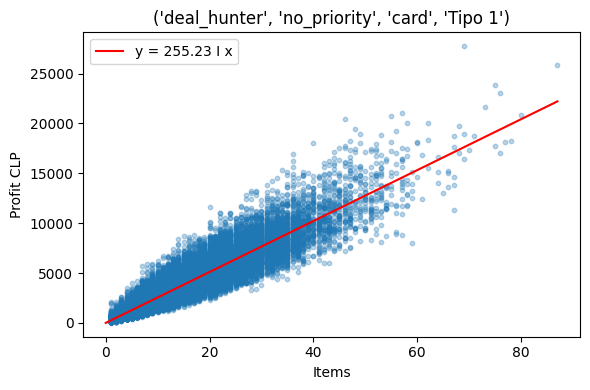

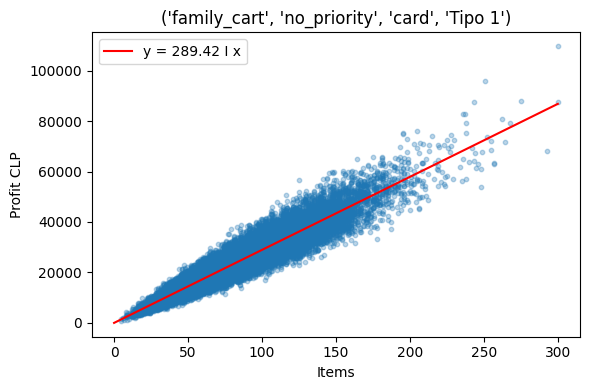

In [8]:
import matplotlib.pyplot as plt

EXAMPLE_COMBOS = [
    ("deal_hunter", "no_priority", "card", "Tipo 1"),
    ("family_cart", "no_priority", "card", "Tipo 1"),
]

for combo in EXAMPLE_COMBOS:
    mask = (customers[GROUP_COLS] == pd.Series(combo, index=GROUP_COLS)).all(axis=1)
    subset = customers.loc[mask]
    if subset.empty:
        print(f"Sin datos para {combo}")
        continue
    model_row = results_df[(results_df[GROUP_COLS] == pd.Series(combo, index=GROUP_COLS)).all(axis=1)]
    if model_row.empty:
        print(f"No se ajustI modelo para {combo}")
        continue
    beta = float(model_row.iloc[0]['beta'])

    plt.figure(figsize=(6, 4))
    plt.scatter(subset['items'], subset['total_profit_clp'], alpha=0.3, s=10)
    x_line = np.linspace(0, subset['items'].max(), 100)
    plt.plot(x_line, beta * x_line, color='red', label=f'y = {beta:.2f} I x')
    plt.title(f"{combo}")
    plt.xlabel("Items")
    plt.ylabel("Profit CLP")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 7. Exportar resultados
Guarda la tabla de coeficientes para usarla en otros cuadernos o en el simulador.

In [9]:
OUTPUT_PATH = Path("profit_analysis_summary.csv")
summary.to_csv(OUTPUT_PATH, index=False)
print(f"Archivo exportado: {OUTPUT_PATH.resolve()}")


Archivo exportado: C:\Users\alvar\OneDrive\Escritorio\Simulador capstone\profit_analysis_summary.csv
